In [1]:
%matplotlib inline
import numpy as np
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from unet import UNet
from load import StockImageDataset, WatermarkDataset
from tqdm.notebook import tqdm
import torchvision.models as models

print('CUDA:', 'Enabled' if torch.cuda.is_available() else 'Disabled')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA: Enabled


## FIRST UNET

In [2]:
from unet import VGGLoss


LEARNING_RATE = 0.001
NUM_EPOCH = 80

model = UNet(4).to(device)
images = WatermarkDataset('logos_rendered', WatermarkDataset.CNN_MODE, scale_im=True, batch_size=4)
images_single = WatermarkDataset('logos_rendered', WatermarkDataset.CNN_MODE, scale_im=False, batch_size=1)
generator1 = torch.Generator().manual_seed(42)
loader = torch.utils.data.DataLoader(images, batch_size=1, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(images_single, batch_size=1, shuffle=True, num_workers=1)

# load pre-trained VGG16 model
loss_vgg = VGGLoss().to(device)
loss_l1 = nn.L1Loss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss = []
epoch = -1

C:\Users\Sam\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Sam\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
NUM_EPOCH = 81

Starting Epoch 80


  0%|          | 0/1903 [00:00<?, ?it/s]

Epoch 80, loss: [27.189146663062274, 58.155258351936936]


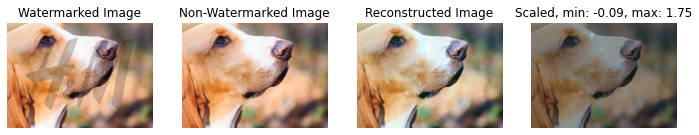

  0%|          | 0/1903 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
if epoch < 0:
    sd = torch.load("unet_training_1.pt")
    epoch = sd['epoch']
    model.load_state_dict(sd['model'])
    optimizer.load_state_dict(sd['opt'])
    train_loss = sd['loss']

print('Starting Epoch', epoch + 1)
while epoch < NUM_EPOCH:
    epoch_loss = [0, 0]
    for j, (nwm, wm) in tqdm(enumerate(loader), total=len(loader)):
        optimizer.zero_grad()
        wm = wm.squeeze(0).to(device)
        nwm = nwm.squeeze(0).to(device)


        pred = model.forward(wm)
        l1 = loss_l1(pred, nwm)
        vgg = loss_vgg(pred, nwm)

        # l1.backward()
        (l1 + 1e-4*vgg).backward()
        optimizer.step()
        epoch_loss[0] += l1.item()
        epoch_loss[1] += vgg.item()

    print(f'Epoch {epoch+1}, loss: {epoch_loss}')
    train_loss.append(epoch_loss)
    torch.save({'model': model.state_dict(), 'opt': optimizer.state_dict(), 'epoch': epoch, 'loss': train_loss}, "unet_training_1.pt")
    with torch.no_grad():
        # get the first batch of data from the validation loader
        nwm, wm = next(iter(val_loader))
        wm = wm.squeeze(0).to(device)
        nwm = nwm.squeeze(0).to(device)
        tensor_image = model.forward(wm).cpu()
        wm = np.moveaxis(wm.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))
        nwm = np.moveaxis(nwm.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))
        tensor_image = np.moveaxis(tensor_image.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))

        f, ax = plt.subplots(1, 4, figsize=(12, 9))

        ax[0].imshow(wm)
        ax[0].set_title('Watermarked Image')
        ax[0].axis('off')
        ax[1].imshow(nwm)
        ax[1].set_title('Non-Watermarked Image')
        ax[1].axis('off')
        ax[2].imshow(np.clip(tensor_image, 0, 1))
        ax[2].set_title('Reconstructed Image')
        ax[2].axis('off')
        lower = tensor_image.min()
        upper = tensor_image.max()
        ax[3].imshow((tensor_image - lower)/(upper - lower))
        ax[3].set_title(f"Scaled, min: {lower:.2f}, max: {upper:.2f}")
        ax[3].axis('off')
        plt.show()
    epoch += 1

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


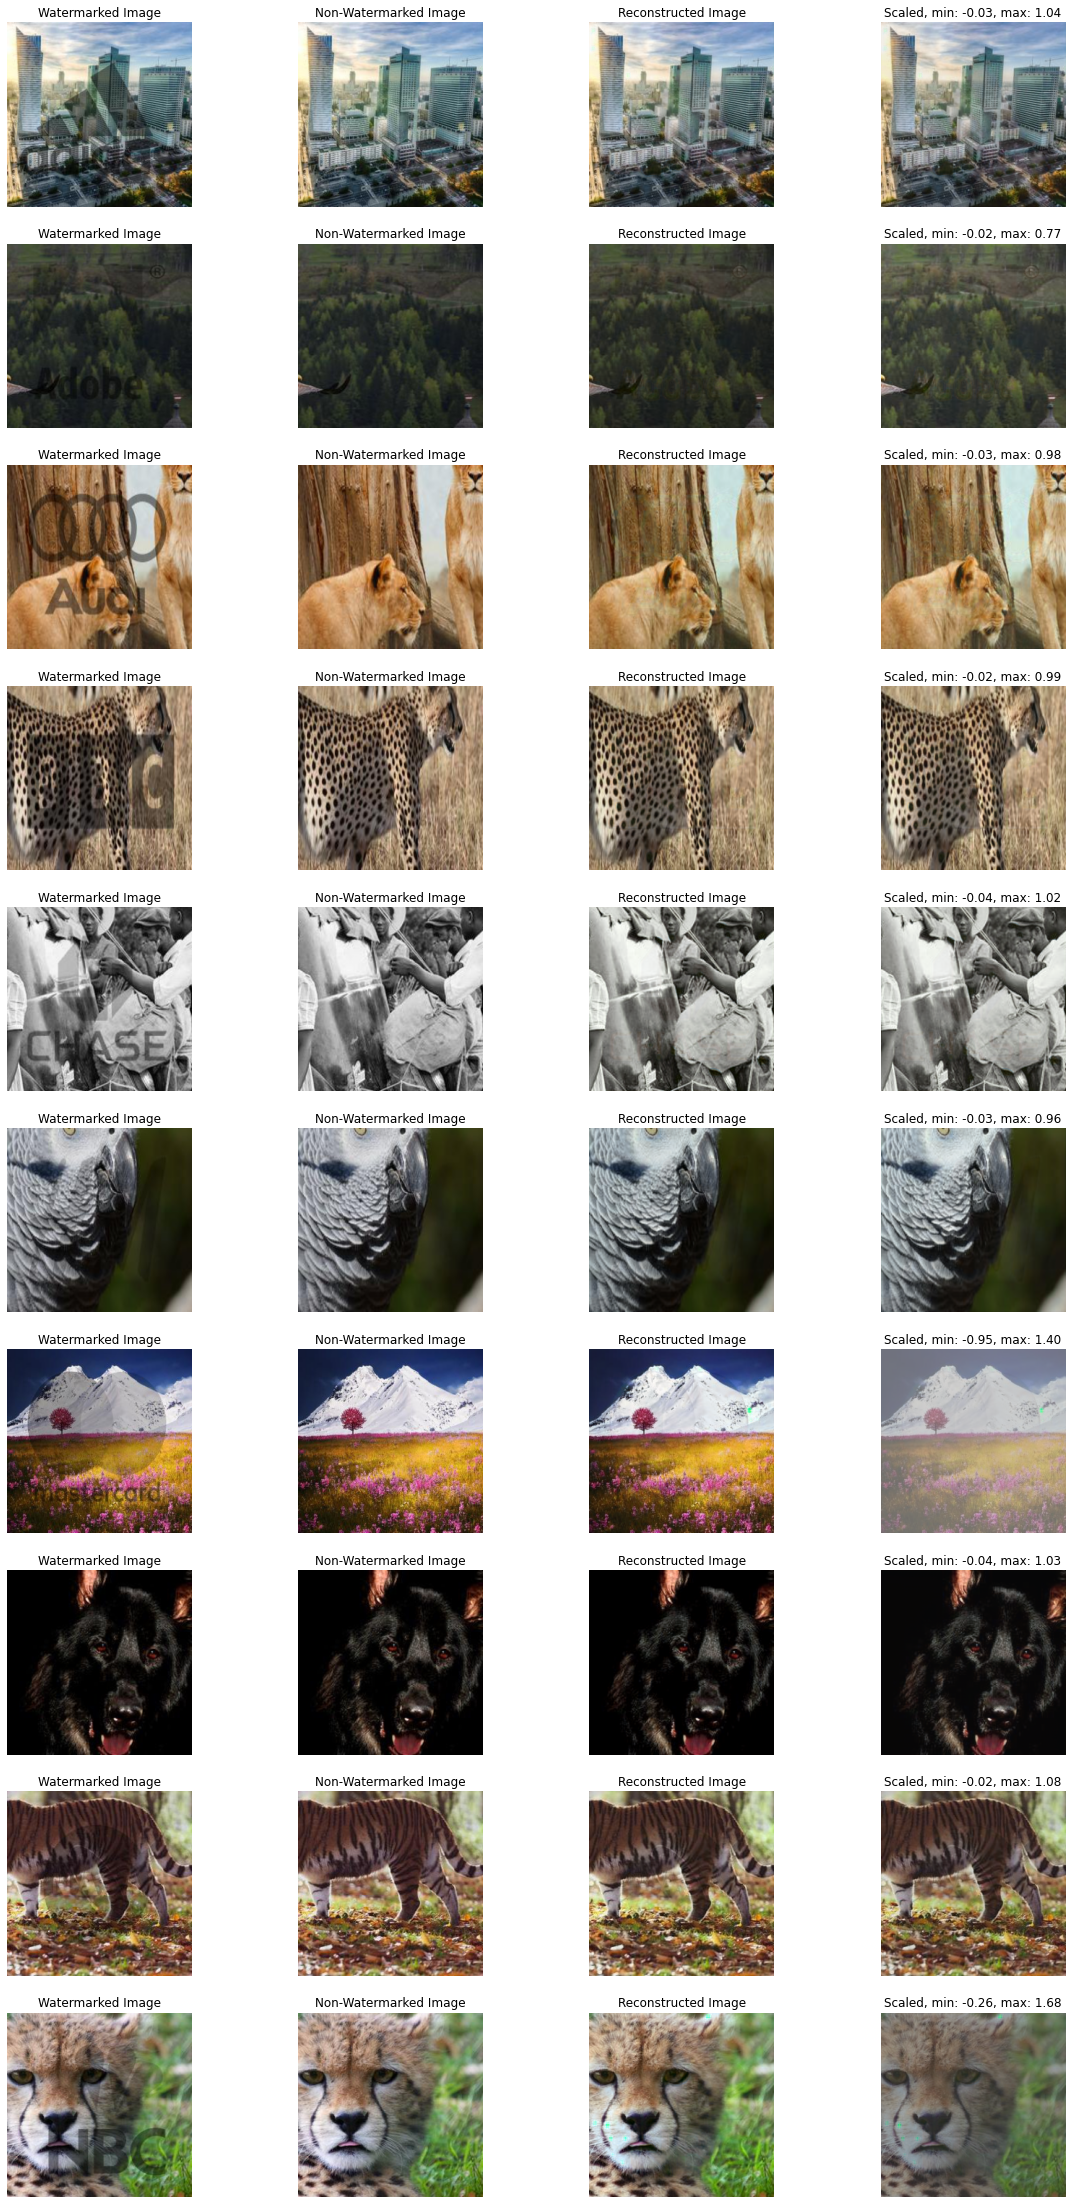

In [10]:

images_single = WatermarkDataset('logos_rendered', WatermarkDataset.CNN_MODE, scale_im=True, batch_size=4)
N = 10
f, ax = plt.subplots(N, 4, figsize=(20,4*N))

for i in range(N):
    with torch.no_grad():
        # get the first batch of data from the validation loader
        # nwm, wm = next(iter(loader))
        nwm, wm = images_single[i]
        print(nwm.shape, wm.shape)
        wm = wm.squeeze(0).to(device)
        nwm = nwm.squeeze(0).to(device)
        tensor_image = model.forward(wm).cpu()
        wm = np.moveaxis(wm.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))
        
        nwm = np.moveaxis(nwm.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))
        
        tensor_image = np.moveaxis(tensor_image.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))

        ax[i, 0].imshow(wm)
        ax[i, 0].set_title('Watermarked Image')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(nwm)
        ax[i, 1].set_title('Non-Watermarked Image')
        ax[i, 1].axis('off')
        ax[i, 2].imshow(np.clip(tensor_image, 0, 1))
        ax[i, 2].set_title('Reconstructed Image')
        ax[i, 2].axis('off')
        lower = tensor_image.min()
        upper = tensor_image.max()
        ax[i, 3].imshow((tensor_image - lower)/(upper - lower))
        ax[i, 3].set_title(f"Scaled, min: {lower:.2f}, max: {upper:.2f}")
        ax[i, 3].axis('off')

<h1> PLOTS </h1>


(80, 2)


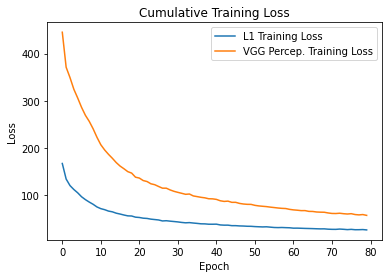

In [4]:
loss_arr = np.array(train_loss)
print(loss_arr.shape)
plt.plot(range(loss_arr.shape[0]), loss_arr[:, 0], label="L1 Training Loss")
plt.plot(range(loss_arr.shape[0]), loss_arr[:, 1], label="VGG Percep. Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Cumulative Training Loss")
plt.legend()
plt.show()

## UNET full data

In [6]:
LEARNING_RATE = 0.01
NUM_EPOCH = 101

model = UNet(4).to(device)
images = WatermarkDataset('logos_rendered', WatermarkDataset.CNN_MODE, scale_im=False, batch_size=10)
images_single = WatermarkDataset('logos_rendered', WatermarkDataset.CNN_MODE, scale_im=False, batch_size=1)

ratio = 0.8  # the fraction of the dataset to use for the first subset

lengths = [int(np.ceil(len(images) * ratio)), len(images) - int(np.ceil(len(images) * ratio))]
train_images, val_images = torch.utils.data.random_split(images, lengths)



loader = torch.utils.data.DataLoader(train_images, batch_size=1, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(images_single, batch_size=1, shuffle=True, num_workers=1)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
train_loss = []

for epoch in range(NUM_EPOCH):
    epoch_loss = 0
    for j, (nwm, wm) in tqdm(enumerate(loader), total=len(loader)):
        wm = wm.to(device)
        nwm = nwm.to(device)
        
        
        pred = model.forward(wm).to(device)
        loss = loss_fn(pred, nwm)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    
    
    print(f'Epoch {epoch+1}, loss: {epoch_loss}')
    train_loss.append(epoch_loss)
    torch.save(model.state_dict(), "unet_fulldata_training_1.pt")
    if epoch % 10 ==0:
        with torch.no_grad():
            # get the first batch of data from the validation loader
            nwm, wm = next(iter(val_loader))
            tensor_image = model.forward(wm).cpu()
            wm = np.moveaxis(wm.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))
            nwm = np.moveaxis(nwm.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))
            tensor_image = np.moveaxis(tensor_image.cpu().numpy()[0, ...], (0, 1, 2), (2, 0, 1))
            

            f, ax = plt.subplots(3, 1)

            ax[0].imshow(wm)
            ax[0].set_title('Watermarked Image')
            ax[0].axis('off')
            ax[1].imshow(nwm)
            ax[1].set_title('Non-Watermarked Image')
            ax[1].axis('off')
            ax[2].imshow(tensor_image)
            ax[2].set_title('Reconstructed Image')
            ax[2].axis('off')
            plt.show()

  0%|          | 0/610 [00:00<?, ?it/s]

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 10, 3, 288, 240]

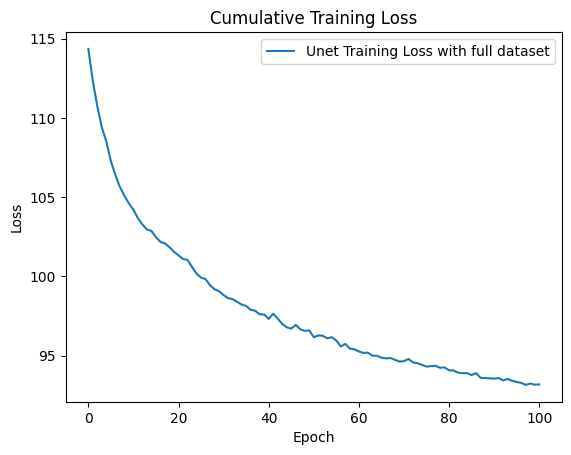

In [ ]:
plt.plot(range(NUM_EPOCH), train_loss, label="Unet Training Loss with full dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Cumulative Training Loss")
plt.legend()
plt.show()